# Projeto Final - 2018  

## X-ray Pneumonia Classification
* Felipe Souza
* Pedro Augusto
* Rafael Dias
* Sergio Marinello


## Problem
#### Part 1: Classify Images

1. Healthy 
2. Pneumonia viral 
3. Pneumonia bacterial

### Data
#### Data Source
O dataset pode ser obtido em:
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


#### Estrutura dos dados
O dataset contido em um arquivo  zip contém a estrutura de diretórios que provê a divisão de treinamento, validação e teste totalizando 5.863 imagens.
 
Abaixo temos a estrutura de pastas, que representa a divisão de teste, treinamento e validação e classe de cada imagem.

* /chest_xray/  
  * test/
    * NORMAL/
    * PNEUMONIA/
  * train/
    * NORMAL/
    * PNEUMONIA/
  * val/
    * NORMAL/
    * PNEUMONIA/


In [1]:

ROOT_DIR = "../input" #kaggle/git dir

# Import library
import os
if not (os.path.exists(ROOT_DIR)):
    print("Using git repository")
    ROOT_DIR = "./kowaslki/input" #colab dir
    if not (os.path.exists(ROOT_DIR)):    
        print("Checking out git repository")
        !git clone https://gitlab.com/rafa.apps/kowaslki.git
else:
    print("Using kaggle repository")
  

Using kaggle repository


## Verificação dos dados

In [2]:
%matplotlib inline

# Basic math libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


# Take note that the .7z directory name is automatically converted to lowercase. 
INPUT_DIR = '%s/chest_xray/chest_xray' % ROOT_DIR


import os.path
# Ensure we're reading the directory correctly.
assert (os.path.exists(INPUT_DIR))

### Carrega diretório

In [3]:
directory = os.listdir(INPUT_DIR)
print("Parent directory includes these folders:", directory)

('Parent directory includes these folders:', ['.DS_Store', 'test', 'train', 'val'])


The folders are split to include train, testing, as well as validation. Create variables pointing to these subfolders

In [4]:
datasetDir = INPUT_DIR
train_folder = '%s/train/' % datasetDir 
val_folder   = '%s/val/' % datasetDir
test_folder  = '%s/test/' % datasetDir

Define the two training class folders of Normal and Pneumonia.

### Load Data
#### Define Training Data

In [5]:
# train 
os.listdir(train_folder)
train_n = train_folder + 'NORMAL/'
train_p = train_folder + 'PNEUMONIA/'

val_n = val_folder + 'NORMAL/'
val_p = val_folder + 'PNEUMONIA/'

test_n = test_folder + 'NORMAL/'
test_p = test_folder + 'PNEUMONIA/'

# Normal 
print("TRAIN NORMAL:", len(os.listdir(train_n)))
print("TRAIN PNEUMONIA:", len(os.listdir(train_p)))
print("TRAIN TOTAL:", len(os.listdir(train_n)) + len(os.listdir(train_p)))


print("VALIDATION NORMAL:", len(os.listdir(val_n)))
print("VALIDATION PNEUMONIA:", len(os.listdir(val_p)))
print("VALIDATION TOTAL:", len(os.listdir(val_n)) + len(os.listdir(val_p)))

print("TEST NORMAL:", len(os.listdir(test_n)))
print("TEST PNEUMONIA:", len(os.listdir(test_p)))
print("TEST TOTAL:", len(os.listdir(test_n)) + len(os.listdir(test_p)))



('TRAIN NORMAL:', 1342)
('TRAIN PNEUMONIA:', 3876)
('TRAIN TOTAL:', 5218)
('VALIDATION NORMAL:', 9)
('VALIDATION PNEUMONIA:', 9)
('VALIDATION TOTAL:', 18)
('TEST NORMAL:', 234)
('TEST PNEUMONIA:', 390)
('TEST TOTAL:', 624)


## Plot de uma imagem normal e uma com pneumonia

In [6]:
rand_n = np.random.randint(0, len(os.listdir(train_n)))
filename =  os.listdir(train_n)[rand_n]
norm_pic_path = train_n + filename

rand_p = np.random.randint(0, len(os.listdir(train_p)))
filename =  os.listdir(train_p)[rand_p]
sic_pic_path = train_p + filename

print('normal picture title:', norm_pic_path)
print('pneumonia picture title:', sic_pic_path)

('normal picture title:', '../input/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0694-0001.jpeg')
('pneumonia picture title:', '../input/chest_xray/chest_xray/train/PNEUMONIA/person264_bacteria_1234.jpeg')


# Plot samples images

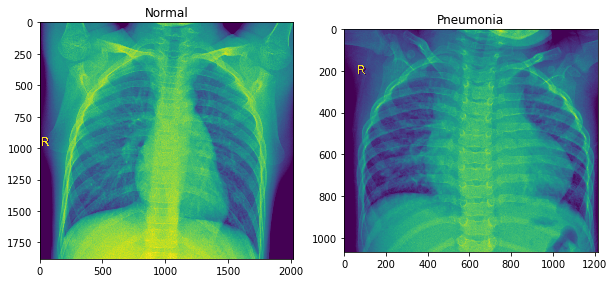

In [7]:
from skimage.io import imread

norm_image = imread(norm_pic_path)
sic_image  = imread(sic_pic_path)

# plot images
f = plt.figure(figsize = (10, 10))

# add_subplot(nrows, ncols, index, **kwargs)
a1 = f.add_subplot(1, 2, 1)
img_plot = plt.imshow(norm_image)
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_image)
a2.set_title('Pneumonia')

## Avalia os dados 

In [8]:
train_n_count = len(os.listdir(train_n))
val_n_count   = len(os.listdir(val_n))
test_n_count  = len(os.listdir(test_n))

train_p_count = len(os.listdir(train_p))
val_p_count   = len(os.listdir(val_p))
test_p_count  = len(os.listdir(test_p))

normal_count = [train_n_count, val_n_count, test_n_count]
sic_count = [train_p_count, val_p_count, test_p_count]

normal_count_total = train_n_count + val_n_count + test_n_count
sic_count_total    = train_p_count + val_p_count + test_p_count

print("Normal", normal_count, "Total:", normal_count_total)
print("Pneumonia", sic_count, "Total:", sic_count_total)


('Normal', [1342, 9, 234], 'Total:', 1585)
('Pneumonia', [3876, 9, 390], 'Total:', 4275)


## Identificando tipos de pneumonia

In [17]:
nbClasses = 2

# classes
NORMAL=0
PNEUMONIA=1

def getLabelFromImgName(imgName):
    if "bacteria" in imgName:
        return PNEUMONIA
    if "virus" in imgName:
        return PNEUMONIA
    return NORMAL

#Read our dataset in batches
def loadDatasetInBatches(split="train",
                         batch_size=32, target_size=(227, 227),
                         dataAugmentator=None, normalize=False):
    from keras.preprocessing.image import load_img, img_to_array
    from random import sample
    from keras.utils import np_utils

    if split not in ["train", "val", "test"]:
        raise ValueError(split + " not recognized. Did you mean 'train', 'val' or 'test'?")
    splitDir = os.path.join(datasetDir, split)
    #Get all file names for that split
    import glob
    all_files = {}
    all_files[NORMAL] = [img for img in glob.glob(splitDir + "/NORMAL/*")]
    all_files[PNEUMONIA] = [img for img in glob.glob(splitDir + "/PNEUMONIA/*")]

    while True:
        fileNames = {}
        for k,class_fileNames in all_files.items():
            # shuffle files and append root folder path
            shuffledFileNames = sample(class_fileNames, len(class_fileNames)) #shuffle images in each epoch
            fileNames[k] = shuffledFileNames

        TOTAL_FILES = sum([len(v) for v in fileNames.values()])
            
        if TOTAL_FILES == 0:
            raise Exception("Missing files for dir: %s" % splitDir)

        #loop of one epoch
        batch, labelList = [], []
        nInBatch = 0
        next_class = 0
        
        idx_per_class = {c:0 for c in range(nbClasses)}
        
        for idx in list(range(TOTAL_FILES)):
            # next class
            next_class = idx % nbClasses
            # class files
            class_files = fileNames[next_class]
            if len(class_files) == 0:
                # ignore empty class
                continue

            # ID for next file for this class
            class_idx = idx_per_class[next_class]
            
            next_imagepath = class_files[class_idx]
            # increment the ID to be used at next iteration
            idx_per_class[next_class] = (class_idx + 1) % len(class_files)
                
            #print(next_imagepath)
                
            img = img_to_array(load_img(next_imagepath, target_size=target_size))
            img = img.astype('float32')
            img /= 255.0

            label = np_utils.to_categorical(getLabelFromImgName(next_imagepath), nbClasses)

            # apply augmentation
            if dataAugmentator is not None:                        
                img = dataAugmentator.random_transform(img)

            batch.append(img)
            labelList.append(label)
            nInBatch += 1

            #if we already have one batch, yields it
            if nInBatch >= batch_size:
                yield np.array(batch), np.array(labelList)
                batch, labelList = [], []
                nInBatch = 0

        #yield the remaining of the batch
        if nInBatch > 0:
            yield np.array(batch), np.array(labelList)


### Percentualmente 

In [18]:
total_images = normal_count_total + sic_count_total

normal_count_pct = normal_count_total / float(total_images)
sic_count_pct = sic_count_total / float(total_images)

print("Percentage normal: {0} %\n".format(normal_count_pct))
print("Percentage pneumonia: {0} %\n".format(sic_count_pct))

Percentage normal: 0.2704778157 %

Percentage pneumonia: 0.7295221843 %



### Observamos que os de treinamento dados são altamente desbalanceados, além disso as dimensões das imagens não são sempre iguais.<br>Dessa forma, precisamos ponderar o peso para treinamento.<br><br>Além disso, observamos que o conjunto de validação é razoavelmente pequeno.

## Data Split

**Before splitting the data,  we will need to obtain the y-labels to go along with X.**

In [19]:
img_width, img_height = 226,226

from keras import backend as K

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

train_samples = train_n_count + train_p_count
validation_samples = val_n_count + val_p_count
print("train_samples %d" % train_samples)
print("validation_samples %d" % validation_samples)

batch_size = 32


train_samples 5218
validation_samples 18


# Gera o modelo

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nbClasses))
model.add(Activation('softmax'))

## Treinamento

In [23]:
epochs = 50

import keras.callbacks
import keras.optimizers as optimizers

checkpoints = keras.callbacks.ModelCheckpoint("./model_1.1_best_val_acc.weights", monitor='val_acc', verbose=1,
                                              save_best_only=True, save_weights_only=True, mode='auto', period=1)
earlyStopcallback = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0,
                                                  patience=5, verbose=1, mode='auto')

callbacks = [checkpoints, earlyStopcallback]

# Compilation
sgd = optimizers.SGD(lr=0.001, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"]) 


In [24]:
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)

# For test we don't need to apply transformation
test_datagen = None

train_generator = loadDatasetInBatches(split='train', dataAugmentator=train_datagen,
                                       batch_size = batch_size, target_size=(img_width, img_height))
val_generator = loadDatasetInBatches(split='val', dataAugmentator=test_datagen,
                                     batch_size = batch_size, target_size=(img_width, img_height))
test_generator = loadDatasetInBatches(split='test', dataAugmentator=test_datagen,
                                      batch_size = batch_size, target_size=(img_width, img_height))

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_samples // float(batch_size),
                              epochs=epochs,
                              validation_data=val_generator,
                              validation_steps=max((validation_samples // float(batch_size)), 1),
                              callbacks=callbacks)

#model.save_weights('baseline_cnn.h5')

Epoch 1/50
163/163 [==============================] - 603s 4s/step - loss: 0.6803 - acc: 0.5845 - val_loss: 0.6772 - val_acc: 0.6875
Epoch 2/50
163/163 [==============================] - 581s 4s/step - loss: 0.6596 - acc: 0.6810 - val_loss: 0.6576 - val_acc: 0.6875
Epoch 3/50
163/163 [==============================] - 543s 3s/step - loss: 0.6175 - acc: 0.7615 - val_loss: 0.6188 - val_acc: 0.7500
Epoch 4/50
163/163 [==============================] - 538s 3s/step - loss: 0.5467 - acc: 0.7972 - val_loss: 0.5545 - val_acc: 0.8125
Epoch 5/50
163/163 [==============================] - 540s 3s/step - loss: 0.4581 - acc: 0.8240 - val_loss: 0.5161 - val_acc: 0.8125
Epoch 6/50
163/163 [==============================] - 532s 3s/step - loss: 0.3924 - acc: 0.8414 - val_loss: 0.4779 - val_acc: 0.8125
Epoch 7/50
163/163 [==============================] - 532s 3s/step - loss: 0.3721 - acc: 0.8451 - val_loss: 0.4744 - val_acc: 0.6875
Epoch 8/50
163/163 [==============================] - 534s 3s/step - 

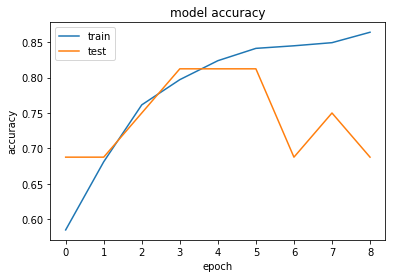

In [25]:
model.load_weights("model_1.1_best_val_acc.weights")

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# Avalia teste

In [29]:
# evaluate the model
scores = model.evaluate_generator(test_generator,                
                                  steps=max(((test_n_count + test_p_count) // float(batch_size)), 1))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


acc: 83.72%


### Observamos que o a acurácia de treinamento/validação diverge bastante conforme o treinamento ocorre

## Decidimos aplicar regularização

In [36]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128,  kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nbClasses))
model.add(Activation('softmax'))

In [37]:
import keras.callbacks
checkpoints = keras.callbacks.ModelCheckpoint("./model_1.2_best_val_acc.weights", monitor='val_acc', verbose=1,
                                              save_best_only=True, save_weights_only=True, mode='auto', period=1)
earlyStopcallback = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0,
                                                  patience=5, verbose=1, mode='auto')

callbacks = [checkpoints, earlyStopcallback]

# Compilation
sgd = optimizers.SGD(lr=0.001, nesterov=True)

model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"]) 



In [38]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_samples // float(batch_size),
                              epochs=epochs,
                              validation_data=val_generator,
                              validation_steps=max(validation_samples // float(batch_size), 1),
                              callbacks=callbacks)


Epoch 1/50
163/163 [==============================] - 609s 4s/step - loss: 3.2289 - acc: 0.5633 - val_loss: 3.2156 - val_acc: 0.5625
Epoch 2/50
163/163 [==============================] - 563s 3s/step - loss: 3.1973 - acc: 0.6490 - val_loss: 3.1841 - val_acc: 0.8125
Epoch 3/50
163/163 [==============================] - 557s 3s/step - loss: 3.1502 - acc: 0.7339 - val_loss: 3.1333 - val_acc: 0.6875
Epoch 4/50
163/163 [==============================] - 573s 4s/step - loss: 3.0712 - acc: 0.7849 - val_loss: 3.0568 - val_acc: 0.6875
Epoch 5/50
163/163 [==============================] - 592s 4s/step - loss: 2.9496 - acc: 0.8184 - val_loss: 2.9822 - val_acc: 0.6875
Epoch 6/50
163/163 [==============================] - 715s 4s/step - loss: 2.8713 - acc: 0.8347 - val_loss: 2.9351 - val_acc: 0.6875
Epoch 7/50
163/163 [==============================] - 585s 4s/step - loss: 2.8256 - acc: 0.8384 - val_loss: 2.9206 - val_acc: 0.6875
Epoch 00007: early stopping


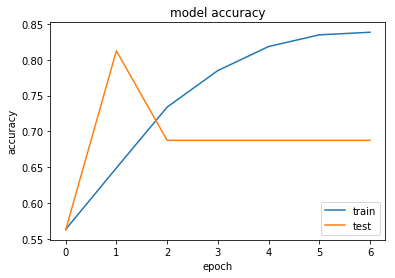

In [39]:
model.load_weights("model_1.1_best_val_acc.weights")

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [40]:
# evaluate the model
scores = model.evaluate_generator(test_generator,
                                  steps=max(((test_n_count + test_p_count) // float(batch_size)), 1))

print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


acc: 83.45%
